In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import plot_models_v_mouse as bp
import model_policies as models
from sklearn.model_selection import train_test_split
import conditional_probs as cprobs
import resample_and_model_reps as reps
import model_fitting as fit
from theory import calculate_escape

In [2]:
data = pd.read_csv(os.path.join('mouse_data.csv'))
data.head()
probs='80-20' # P(high)-P(low)
seq_nback=3 # history length for conditional probabilites
train_prop=0.7 # for splitting sessions into train and test
seed = np.random.randint(1000) # set seed for reproducibility

data = data.loc[data.Condition==probs] # segment out task condition
data = cprobs.add_history_cols(data, seq_nback) # set history labels up front
data.head()
# train_session_ids, test_session_ids = train_test_split(data.Session.unique(), 
#                                                        train_size=train_prop, random_state=seed) # split full df for train/test

,Trial,blockTrial,Decision,Switch,Reward,Condition,Target,blockLength,Session,Mouse,decision_seq,reward_seq,history,RL_history
0,11.0,11.0,0.0,1.0,1.0,80-20,0.0,12.0,m1_63,m1,NaN,NaN,NaN,NaN
1,12.0,12.0,0.0,0.0,1.0,80-20,0.0,12.0,m1_63,m1,NaN,NaN,NaN,NaN
2,13.0,0.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1,NaN,NaN,NaN,NaN
3,14.0,1.0,0.0,0.0,0.0,80-20,1.0,53.0,m1_63,m1,000,110,AAa,RRr
4,15.0,2.0,1.0,1.0,1.0,80-20,1.0,53.0,m1_63,m1,000,100,Aaa,Rrr


In [3]:
session_ids = data.Session.unique()
# session_ids = ['m1_63','m1_64','m1_65','m1_67', 'm1_92', 'm1_16', 'm1_17', 'm1_18']
print(session_ids)

['m1_63' 'm1_64' 'm1_65' 'm1_66' 'm1_67' 'm1_92' 'm1_16' 'm1_17' 'm1_18'
 'm1_19' 'm1_20' 'm1_21' 'm1_22' 'm1_23' 'm1_24' 'm1_25' 'm1_26' 'm1_27'
 'm1_28' 'm1_29' 'm1_30' 'm1_31' 'm1_32' 'm1_33' 'm1_34' 'm1_35' 'm1_36'
 'm1_37' 'm1_61' 'm2_77' 'm2_78' 'm2_79' 'm2_80' 'm2_81' 'm2_100' 'm2_16'
 'm2_17' 'm2_18' 'm2_19' 'm2_20' 'm2_21' 'm2_22' 'm2_23' 'm2_24' 'm2_25'
 'm2_26' 'm2_27' 'm2_28' 'm2_29' 'm2_30' 'm2_31' 'm2_32' 'm2_33' 'm2_34'
 'm2_35' 'm2_36' 'm2_37' 'm2_38' 'm2_39' 'm3_68' 'm3_69' 'm3_70' 'm3_71'
 'm3_72' 'm3_80' 'm3_94' 'm3_14' 'm3_15' 'm3_16' 'm3_17' 'm3_18' 'm3_19'
 'm3_20' 'm3_21' 'm3_22' 'm3_23' 'm3_24' 'm3_25' 'm3_26' 'm3_27' 'm3_28'
 'm3_29' 'm3_30' 'm3_31' 'm3_32' 'm3_33' 'm3_34' 'm3_35' 'm3_36' 'm4_60'
 'm4_61' 'm4_62' 'm4_63' 'm4_64' 'm4_89' 'm4_8' 'm4_9' 'm4_10' 'm4_11'
 'm4_12' 'm4_13' 'm4_14' 'm4_15' 'm4_16' 'm4_17' 'm4_18' 'm4_19' 'm4_20'
 'm4_21' 'm4_22' 'm4_23' 'm4_24' 'm4_25' 'm4_26' 'm4_27' 'm5_63' 'm5_64'
 'm5_65' 'm5_66' 'm5_89' 'm5_15' 'm5_16' 'm5_17' 'm5

In [4]:

data['block_pos_rev'] = data['blockTrial'] - data['blockLength'] # reverse block position from transition
data['model']='mouse'
data['highPort'] = data['Decision']==data['Target'] # boolean, chose higher probability port

train_features, _, _ = reps.pull_sample_dataset(session_ids, data)
test_features, _, block_pos_core = reps.pull_sample_dataset(session_ids, data)
print(block_pos_core)
block_pos_core.to_csv('./block_pos_core.csv', index=False)
bpos_mouse = bp.get_block_position_summaries(block_pos_core)
bpos_mouse['condition'] = 'mouse'
print(bpos_mouse)

        Trial  blockTrial  Decision  Switch  Reward Condition  Target  \
0        11.0        11.0       0.0     1.0     1.0     80-20     0.0   
1        12.0        12.0       0.0     0.0     1.0     80-20     0.0   
2        13.0         0.0       0.0     0.0     0.0     80-20     1.0   
3        14.0         1.0       0.0     0.0     0.0     80-20     1.0   
4        15.0         2.0       1.0     1.0     1.0     80-20     1.0   
...       ...         ...       ...     ...     ...       ...     ...   
117329  859.0        63.0       1.0     0.0     0.0     80-20     0.0   
117330  860.0        64.0       1.0     0.0     0.0     80-20     0.0   
117331  861.0        65.0       1.0     0.0     1.0     80-20     0.0   
117332  862.0        66.0       1.0     0.0     0.0     80-20     0.0   
117333  863.0        67.0       1.0     0.0     0.0     80-20     0.0   

        blockLength Session Mouse decision_seq reward_seq history RL_history  \
0              12.0   m1_63    m1          

In [5]:
L1 = 1 # choice history
L2 =  5 # choice * reward history
L3 = 0
memories = [L1, L3, L2, 1]

lr = models.fit_logreg_policy(train_features, memories) # refit model with reduced histories, training set
model_probs = models.compute_logreg_probs(test_features, lr_args=[lr, memories])

In [6]:
print(lr)

LogisticRegression(fit_intercept=False)


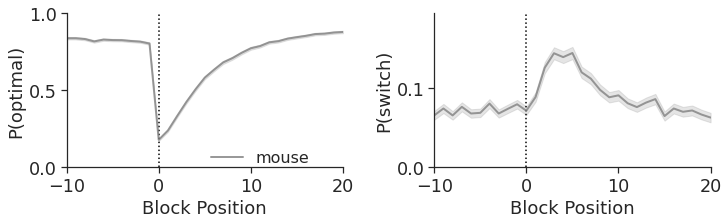

In [7]:
model_choices, model_switches = models.model_to_policy(model_probs, test_features, policy='stochastic')

linear = reps.reconstruct_block_pos(block_pos_core, model_choices, model_switches)
linear_model = bp.get_block_position_summaries(linear)
linear_model['condition'] = 'model' # label model predictions as such
linear_model_v_mouse = pd.concat((bpos_mouse, linear_model)) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}
bp.plot_by_block_position(bpos_mouse, subset='condition', color_dict = color_dict)

In [8]:
for i in range(1):
    print(len(test_features[0][0]))
    # print(model_choices[0])
    # print(model_switches[0])
    # s = 
    # print(model_choices[i])

587


In [9]:
history_length = 5
from Lyapunov_Worm_deconstruction import Lyapunov_Worm_Deconstruction
from tqdm import tqdm
dim = 2
varargin = {
    'step_num': 400,  # how many steps to run the brain circuit before executing the next movement
    'tau': np.ones(dim),  # decay time constant
    'weights_in': np.ones(dim) * 1.,  # input weights
    'rs': np.ones(dim) * .5,  #
    'w': np.ones(dim) * 4,  # weight of mutual inhibition
    'k': 7. * np.ones(dim),  # sigmoid center
    'n': 1.0 * np.ones(dim),  # sigmoid slope
    'bi': np.ones(dim) * 5.,  # baseline production
    'dt': 1.2,  # size of timesteps
    'nsf': 0.85,  # noise level
    'w_avg_comp': 0.5,
    'w_std_comp': 0.5
}
choice_list = []
switches_list = []
ALL = 0
num = 0
for session in tqdm(range(len(test_features))):
    idx = 0
    net = Lyapunov_Worm_Deconstruction(varargin=varargin, dim=dim)
    choice_history_session = test_features[session][0]
    reward_history_session = test_features[session][1]
    choice_list_session = []
    switches_list_session = []
    for trial in range(choice_history_session.shape[0]):
        idx += 1
        # print(idx)
        reward_history_list = [[0.],[0.]]
        lf = max(0, trial - history_length)
        choice_history = choice_history_session[lf:trial]
        reward_history = reward_history_session[lf: trial]
        # print((lf, trial+1))
        # reward_history[reward_history==0] = -1
        decay_list = np.arange(0, len(reward_history), 1)
        decay_list = decay_list[::-1]
        decay_list = 2.1*np.exp(-decay_list/1.3)
        # print(decay_list)
        reward_history = reward_history * decay_list 
        reward_history_list[0] += reward_history[choice_history==0].tolist()
        reward_history_list[1] += reward_history[choice_history==1].tolist()
        # print(reward_history_list)
        reward_history = np.array(reward_history_list)
        last_choice = choice_history[-1] if len(choice_history) > 0 else None
        init_point = None
        # print(reward_history)
        if last_choice == 0:
            init_point = [10.,2.]
        elif last_choice == 1:
            init_point = [2., 10.]
        choice= net.decide(history=reward_history, init=True, init_point=init_point)
        choice_list_session.append(choice)
        if trial == 0:
            switches_list_session.append(0)
        else:
            if choice != last_choice:
                switches_list_session.append(1)
            else:
                switches_list_session.append(0)
        I1 = np.mean(reward_history_list[0]) * varargin['w_avg_comp']
        I2 = np.mean(reward_history_list[1]) * varargin['w_avg_comp']
        # print((noise1, noise2))
        noise1 = np.sqrt(varargin['nsf'] **2 + (np.std(reward_history_list[0])*varargin['w_std_comp']) **2) 
        noise2 = np.sqrt(varargin['nsf'] **2 + (np.std(reward_history_list[1])* varargin['w_std_comp']) **2)
        P1, P2 = calculate_escape(I=[I1, I2], noise=[noise1, noise2])
        # print((P1,P2))
        target = choice_history_session[trial]
        LL = (1-target) * np.log(float(P1)) + target * np.log(float(P2))
        num += 1
        # print(LL)
        ALL += LL
    choice_list.append(choice_list_session)
    # print(choice_list)
    switches_list.append(switches_list_session)
        # print(choice)

  0%|          | 0/159 [00:00<?, ?it/s]/tmp/ipykernel_9002/3141461564.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  reward_history = np.array(reward_history_list)
100%|██████████| 159/159 [30:40<00:00, 11.57s/it]


In [10]:
print(ALL/num)

-0.49666616278084535


In [11]:
print(len(choice_list[0]))
print(len(switches_list[0]))

587
587


In [12]:
block_pos_model = reps.reconstruct_block_pos(block_pos_core, choice_list, switches_list)
block_pos_model.to_csv('./block_pos_model.csv', index=False)
bpos_model = bp.get_block_position_summaries(block_pos_model)
print(bpos_model)

    block_pos     phigh  phigh_std   pswitch  pswitch_std     n
0       -20.0  0.823926   0.381000  0.077301     0.267150  1630
1       -19.0  0.807554   0.394340  0.086930     0.281818  1668
2       -18.0  0.820437   0.383936  0.069108     0.253713  1693
3       -17.0  0.816397   0.387272  0.069284     0.254010  1732
4       -16.0  0.805979   0.395557  0.085166     0.279208  1773
5       -15.0  0.817329   0.386503  0.074503     0.262661  1812
6       -14.0  0.816955   0.386808  0.073434     0.260918  1852
7       -13.0  0.816640   0.387064  0.080021     0.271398  1887
8       -12.0  0.831513   0.374395  0.061882     0.241005  1923
9       -11.0  0.825688   0.379474  0.076453     0.265789  1962
10      -10.0  0.831920   0.374030  0.067830     0.251517  2005
11       -9.0  0.831061   0.374789  0.073028     0.260246  2054
12       -8.0  0.825548   0.379588  0.070543     0.256122  2098
13       -7.0  0.808905   0.393255  0.080241     0.271729  2156
14       -6.0  0.807360   0.394462  0.06

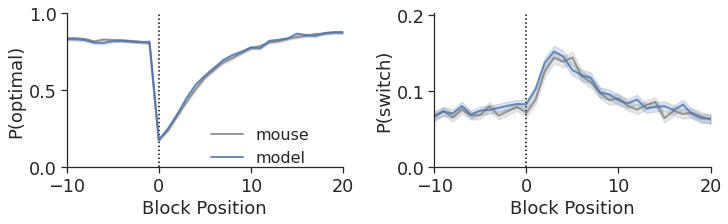

In [13]:

bpos_model['condition'] = 'model' # label model predictions as such
bpos_model_v_mouse = pd.concat((bpos_mouse, bpos_model)) # agg df with model predictions and mouse data
color_dict = {'mouse': 'gray', 'model': sns.color_palette()[0]}#plot_config['model_seq_col']}
bp.plot_by_block_position(bpos_model_v_mouse, subset='condition', color_dict = color_dict)

In [14]:
df_mouse_symm_reference = cprobs.calc_conditional_probs(data, symm=True, 
                                                        action=['Switch']).sort_values('pswitch')

   history  pdecision      n  pdecision_err   pswitch  pswitch_err
0      AAA   0.515170  46738       0.002312  0.009414     0.000447
16     aAA   0.513608  11207       0.004721  0.009637     0.000923
8      AaA   0.510312  11879       0.004587  0.015153     0.001121
24     aaA   0.526602   3496       0.008444  0.022311     0.002498
13     AbB   0.647059    102       0.047318  0.029412     0.016729
21     aBB   0.488516   2743       0.009544  0.033540     0.003438
20     aBA   0.474359     78       0.056539  0.038462     0.021775
4      ABA   0.333333     24       0.096225  0.041667     0.040789
28     abA   0.538200    589       0.020542  0.044143     0.008464
29     abB   0.518248    685       0.019091  0.045255     0.007942
25     aaB   0.474044   2485       0.010017  0.053924     0.004531
5      ABB   0.442857    140       0.041981  0.057143     0.019617
2      AAa   0.512338  13454       0.004309  0.061617     0.002073
9      AaB   0.506289    636       0.019825  0.075472     0.01

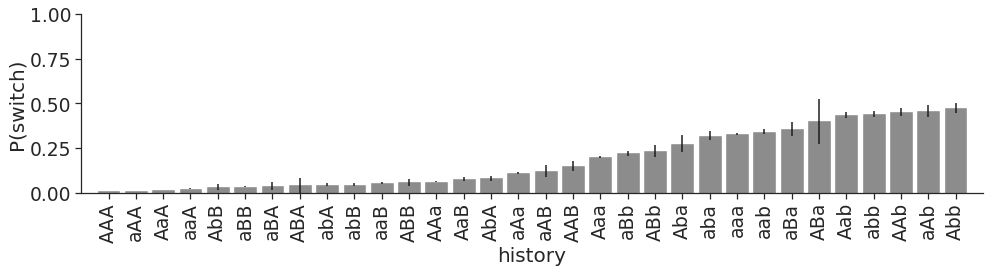

In [15]:
df_mouse_symm = cprobs.calc_conditional_probs(block_pos_core, symm=True, action=['Switch', 'Decision'])
df_mouse_symm = cprobs.sort_cprobs(df_mouse_symm, df_mouse_symm_reference.history.values)
print(df_mouse_symm)
bp.plot_sequences(df_mouse_symm, alpha=0.5) 

In [16]:
print()

   history   pswitch      n  pswitch_err
0      AAA  0.013929  46738     0.000542
16     aAA  0.026144  11207     0.001507
8      AaA  0.039481  11879     0.001787
24     aaA  0.063501   3496     0.004124
13     AbB  0.058824    102     0.023298
21     aBB  0.003281   2743     0.001092
20     aBA  0.435897     78     0.056147
4      ABA  0.333333     24     0.096225
28     abA  0.040747    589     0.008146
29     abB  0.026277    685     0.006112
25     aaB  0.005634   2485     0.001501
5      ABB  0.007143    140     0.007117
2      AAa  0.089490  13454     0.002461
9      AaB  0.012579    636     0.004419
12     AbA  0.028881    277     0.010062
18     aAa  0.138966   4663     0.005066
17     aAB  0.010870     92     0.010810
1      AAB  0.056604    159     0.018326
10     Aaa  0.208597   5839     0.005317
23     aBb  0.100098   1019     0.009402
7      ABb  0.182857    175     0.029220
14     Aba  0.175824     91     0.039905
30     aba  0.276056    355     0.023727
26     aaa  0.30

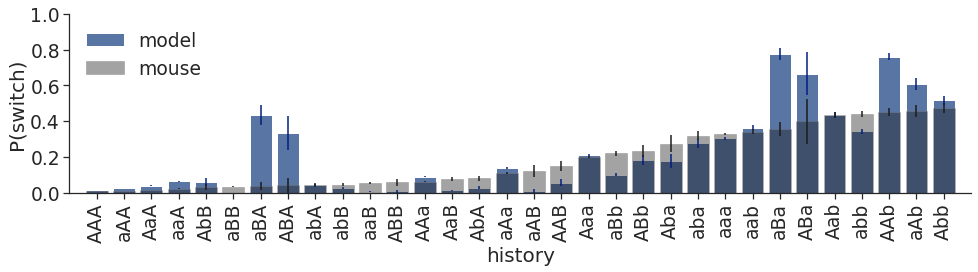

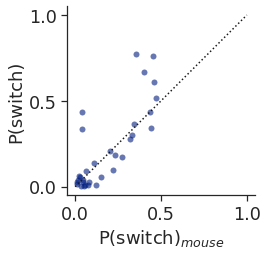

In [17]:
symm_cprobs_model = cprobs.calc_conditional_probs(block_pos_model, symm=True, action=['Switch'])
symm_cprobs_model = cprobs.sort_cprobs(symm_cprobs_model, df_mouse_symm.history.values)
print(symm_cprobs_model)
bp.plot_sequences(df_mouse_symm, overlay=symm_cprobs_model, main_label='mouse', overlay_label='model')
bp.plot_scatter(df_mouse_symm, symm_cprobs_model)

In [18]:
sum = 0
corr = 0
for idx in range(len(choice_list)):
    targets = test_features[idx][0]
    preds = choice_list[idx]
    corr += np.sum(preds==targets) 
    sum += len(preds)
print(corr/sum)

0.8904920994767075


In [19]:
sum = 0
corr = 0
for idx in range(len(choice_list)):
    targets = model_switches[idx]
    preds = np.array(switches_list[idx])
    corr += np.sum(preds==targets) 
    sum += len(preds)
print(switches_list[0])
print(model_switches[0])
print(corr/sum)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
print(np.sum(block_pos_model['Switch'] == data['Switch']) / len(data))
print(np.sum(block_pos_model['Decision'] == data['Decision']) / len(data))                                                                                  

0.8909778921710673
0.8904920994767075


In [21]:
a = np.sum((block_pos_model['Switch'] == 0 ) & (data['Switch'] == 0)) / np.sum(data['Switch'] == 0)
b = np.sum((block_pos_model['Switch'] == 1 ) & (data['Switch'] == 0)) / np.sum(data['Switch'] == 0)
c = np.sum((block_pos_model['Switch'] == 0 ) & (data['Switch'] == 1)) / np.sum(data['Switch'] == 1)
d = np.sum((block_pos_model['Switch'] == 1 ) & (data['Switch'] == 1)) / np.sum(data['Switch'] == 1)
print(a.round(3)) 
print(b.round(3))
print(c.round(3))
print(d.round(3))

0.937
0.063
0.755
0.245


In [22]:
a = np.sum((block_pos_model['Decision'] == 0 ) & (data['Decision'] == 0)) / np.sum(data['Decision'] == 0)
b = np.sum((block_pos_model['Decision'] == 1 ) & (data['Decision'] == 0)) / np.sum(data['Decision'] == 0)
c = np.sum((block_pos_model['Decision'] == 0 ) & (data['Decision'] == 1)) / np.sum(data['Decision'] == 1)
d = np.sum((block_pos_model['Decision'] == 1 ) & (data['Decision'] == 1)) / np.sum(data['Decision'] == 1)
print(a.round(3))
print(b.round(3))
print(c.round(3))
print(d.round(3))


0.89
0.11
0.109
0.891
